In [1]:
#Import necessary libraries

import pandas as pd 
import numpy as np
import nltk
import seaborn as sns 
import warnings
import matplotlib.pyplot as plt 
import re

from sklearn.utils import resample
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import LancasterStemmer
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import LancasterStemmer
from string import punctuation
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.utils import pad_sequences
from keras import regularizers

In [3]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\BigData\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
#Config for data visualize
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

sns.set()
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

%matplotlib inline

In [4]:
#Import train and test data

train = pd.read_csv('C:/Users/BigData/Downloads/Sentiment Analysis/data/training.1600000.processed.noemoticon.csv', encoding = 'latin1')
test = pd.read_csv('C:/Users/BigData/Downloads/Sentiment Analysis/data/testdata.manual.2009.06.14.csv', encoding  = 'latin1')

In [5]:
#First 5 rows of train data

train.head()

,polarity of tweet,id of the tweet,date of the tweet,query,user,text of the tweet
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [6]:
# Paraphrase the data columns 

train.columns = ['Class', 'id', 'date', 'query', 'user', 'text']
train.drop(['query'], axis = 1, inplace=True)

In [7]:
train.head()

,Class,id,date,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,joy_wolf,@Kwesidei not the whole crew


In [8]:
#Data dimension 

print(train.shape)
print(test.shape)

(1048572, 5)
(515, 6)


In [9]:
train.Class.value_counts()

0    799996
4    248576
Name: Class, dtype: int64

<AxesSubplot:xlabel='Class', ylabel='count'>

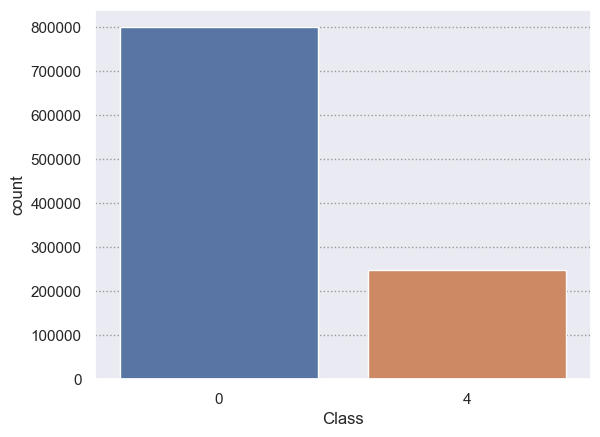

In [10]:
# 0 - is negative 4 - is positive
sns.countplot(train['Class'])

In [11]:
#Decrease the majority class 

majority = train[train['Class'] == 0]
minor = train[train['Class'] == 4]
minority_class_shape = minor.shape[0]

df_majority_new = resample(majority, replace=False, 
                          n_samples = minority_class_shape,
                          random_state = 42)
df_majority_new.shape

(248576, 5)

In [12]:
train_df = df_majority_new.append(minor)
train_df.shape

(497152, 5)

In [13]:
train_df.tail()

,Class,id,date,user,text
1048567,4,1960186342,Fri May 29 07:33:44 PDT 2009,Madelinedugganx,My GrandMa is making Dinenr with my Mum
1048568,4,1960186409,Fri May 29 07:33:43 PDT 2009,OffRoad_Dude,Mid-morning snack time... A bowl of cheese noo...
1048569,4,1960186429,Fri May 29 07:33:44 PDT 2009,Falchion,@ShaDeLa same here say it like from the Termi...
1048570,4,1960186445,Fri May 29 07:33:44 PDT 2009,jonasobsessedx,@DestinyHope92 im great thaanks wbuu?
1048571,4,1960186607,Fri May 29 07:33:45 PDT 2009,sugababez,cant wait til her date this weekend


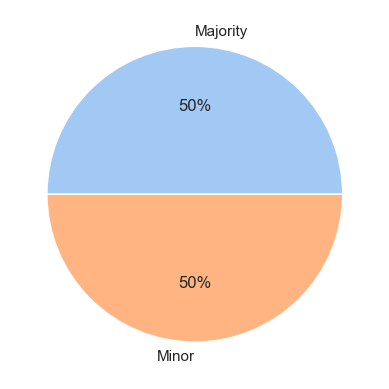

In [14]:
#Define data

num = [train_df[train_df['Class'] == 0].shape[0], minor.shape[0]]
labels = ['Majority', 'Minor']

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:2]

#create pie chart
plt.pie(num, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

#### EDA

In [15]:
#Let's take only tweets

tweets = train_df['text']
tweets

212188     @amruth92 early bird! and you didnt reply to m...
674330     It is sooo hot tonight. I wish I had my pool u...
752234                       @darkandrez No washing clothes 
415739                               @asexiness  That sucks!
138859     until now, i haven't watch yet the finale of A...
                                 ...                        
1048567             My GrandMa is making Dinenr with my Mum 
1048568    Mid-morning snack time... A bowl of cheese noo...
1048569    @ShaDeLa same here  say it like from the Termi...
1048570               @DestinyHope92 im great thaanks  wbuu?
1048571                 cant wait til her date this weekend 
Name: text, Length: 497152, dtype: object

In [16]:
#Mean tweet lens
tweet_lens = [len(t.split()) for t in tweets.values]
len_mean = np.mean(tweet_lens)
len_mean

13.20797261199794

<AxesSubplot:title={'center':'Distribution of tweets'}, ylabel='Count'>

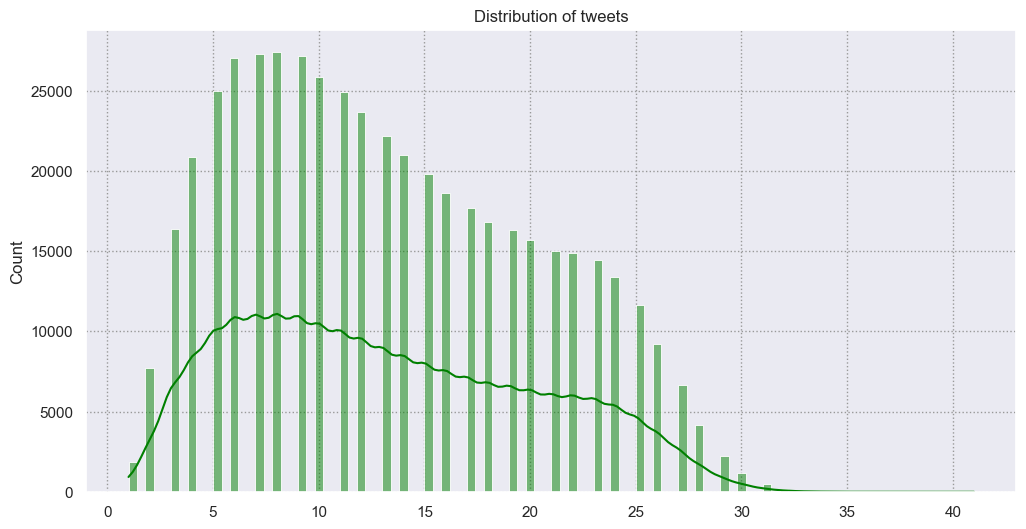

In [17]:
plt.figure(figsize = (12, 6))

plt.title('Distribution of tweets')
sns.histplot(tweet_lens,bins=100, kde=True, color='green')

In [18]:
# Define the stop words
words_removed = list(stopwords.words('english'))+list(punctuation)
words_removed[:5]

['i', 'me', 'my', 'myself', 'we']

In [19]:
#Transform tweets to list 
lst_tweets = tweets.tolist()
lst_tweets[0]

'@amruth92 early bird! and you didnt reply to my facebook wall post  xo'

In [20]:
#Let's clean the data

def clean(train_df):    
    final_tweets = []
    final_tweets_joined = []
    for i in train_df.index:
        text = re.sub('[^a-zA-Z]', ' ', train_df['text'][i])
        text = text.lower()
        text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
        text=re.sub("(\\d|\\W)+"," ",text)
        text = text.split()
        lem = WordNetLemmatizer()
        text = [lem.lemmatize(word) for word in text if not word in words_removed] 
        final_tweets.append(text)
        text_new = ' '.join(text)
        final_tweets_joined.append(text_new)
    return final_tweets, final_tweets_joined

In [21]:
cleaned_texts = clean(train_df)

In [22]:
data_analysis = pd.DataFrame()
data_analysis['tweets'] = cleaned_texts[0]
data_analysis['Class'] = train_df['Class'].values
data_analysis.head()

,tweets,Class
0,"[amruth, early, bird, didnt, reply, facebook, ...",0
1,"[sooo, hot, tonight, wish, pool, outside, skin...",0
2,"[darkandrez, washing, clothes]",0
3,"[asexiness, suck]",0
4,"[watch, yet, finale, ai, waiting, replay, alwa...",0


In [23]:
clean_data = pd.DataFrame()
clean_data["tweets"] = cleaned_texts[1]
clean_data["Class"] = train_df["Class"].values
clean_data.head()

,tweets,Class
0,amruth early bird didnt reply facebook wall po...,0
1,sooo hot tonight wish pool outside skinny dipp...,0
2,darkandrez washing clothes,0
3,asexiness suck,0
4,watch yet finale ai waiting replay always miss...,0


In [25]:
positive = data_analysis[data_analysis['Class'] == 4]['tweets'].tolist()
negative = data_analysis[data_analysis['Class'] == 0]['tweets'].tolist()

In [26]:
positive_all = " ".join([word for sent in positive for word in sent ])
negative_all = " ".join([word for sent in negative for word in sent ])

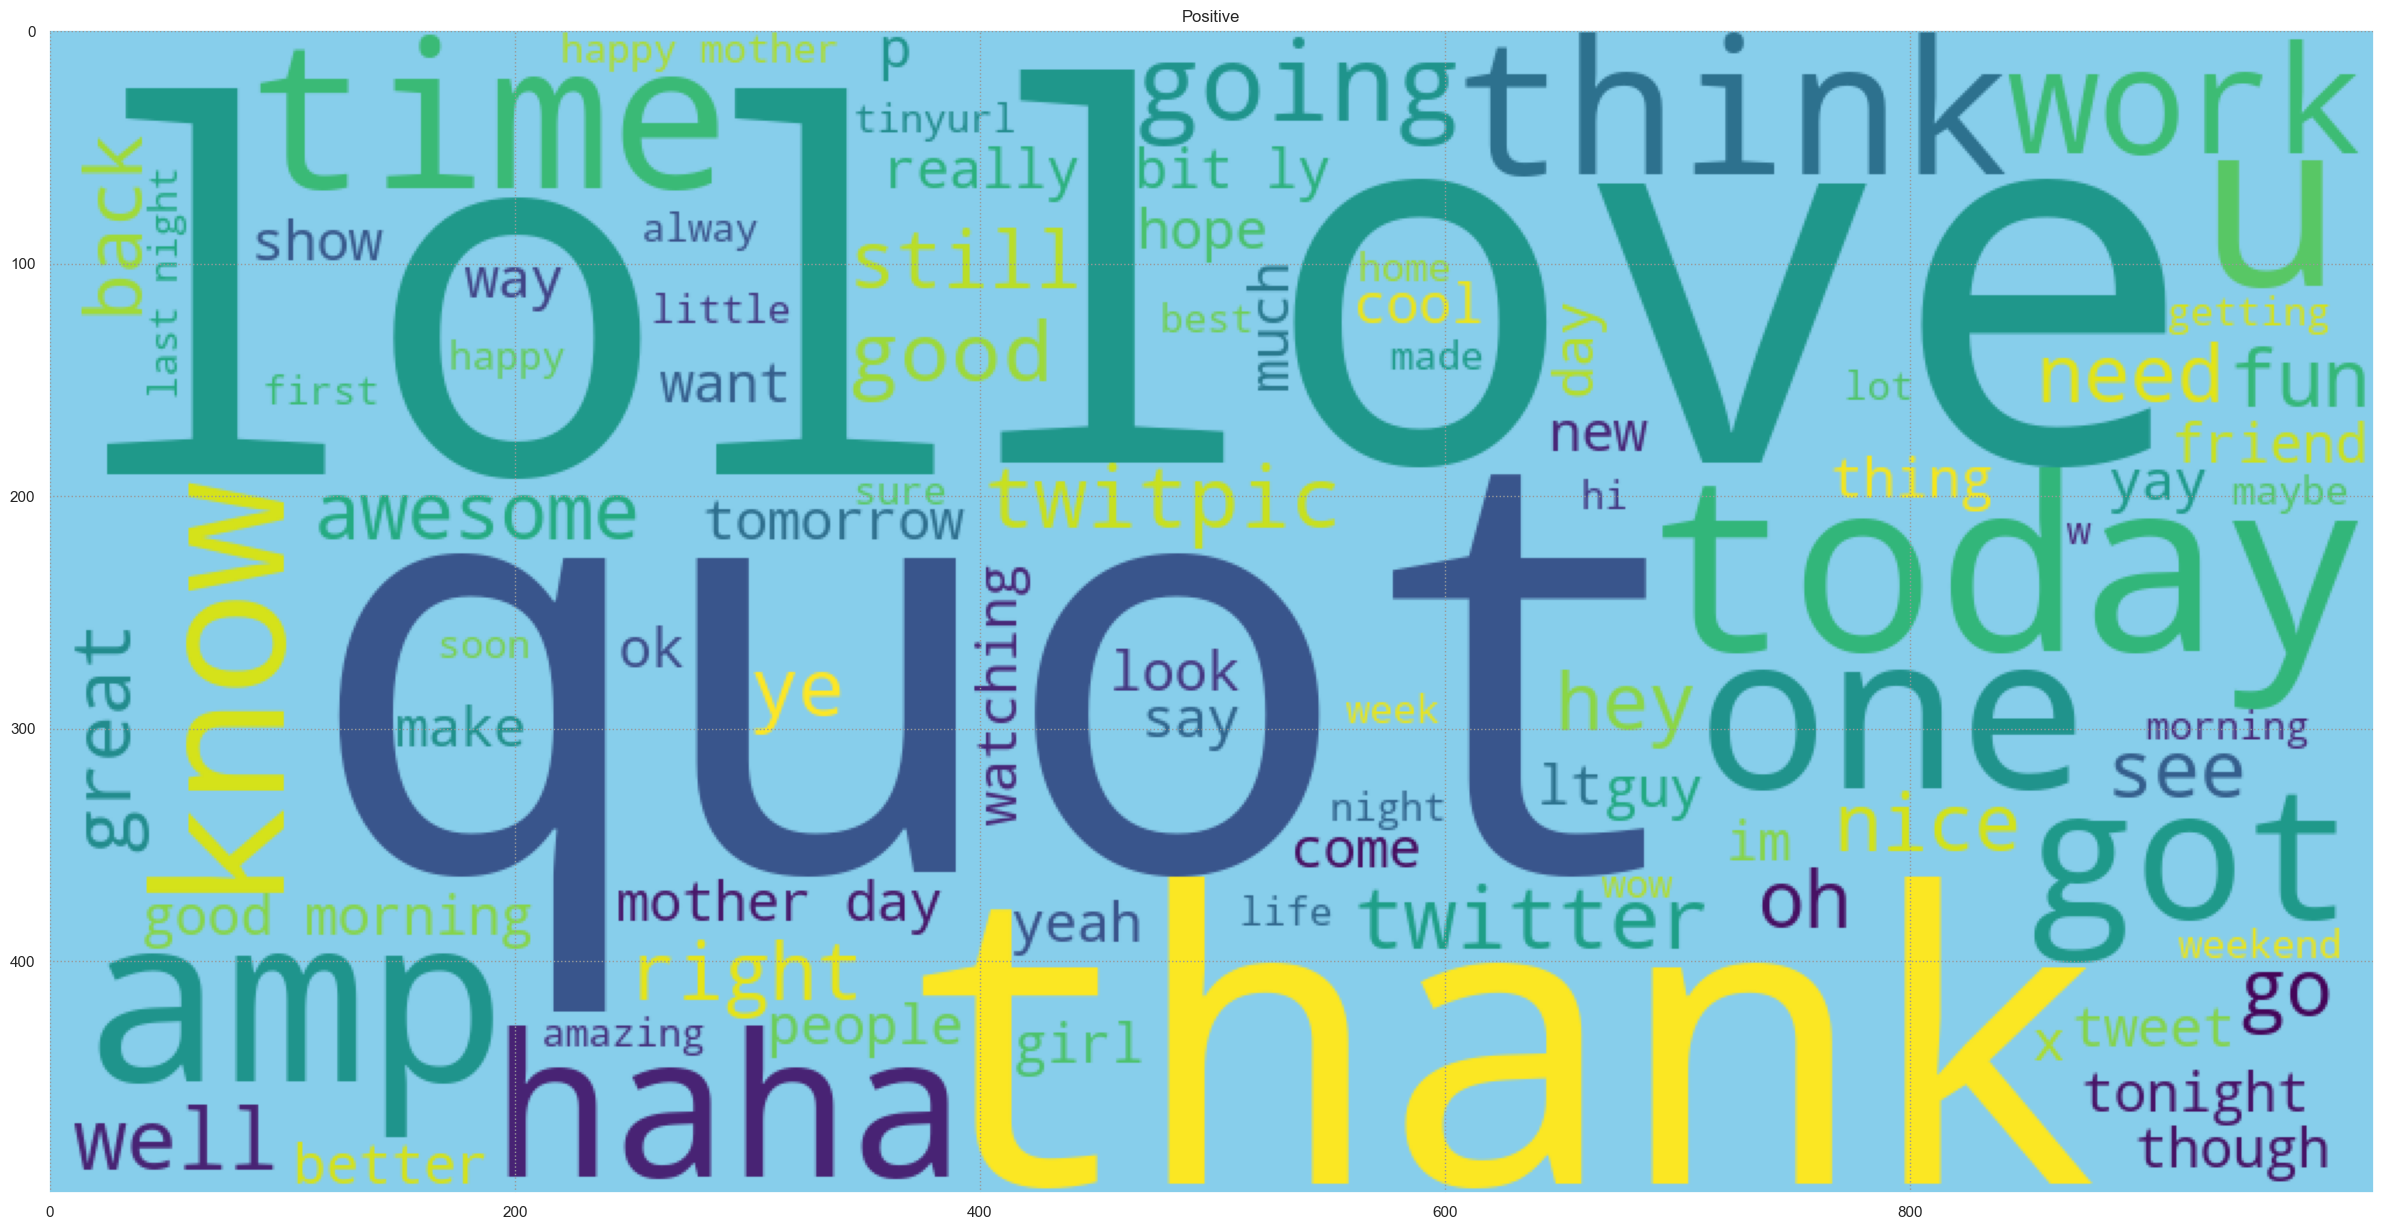

In [27]:
WordCloud()
wordcloud = WordCloud(width=1000,
                      height=500,
                      background_color='skyblue',
                      max_words = 90).generate(positive_all)

plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.title("Positive")
plt.show()

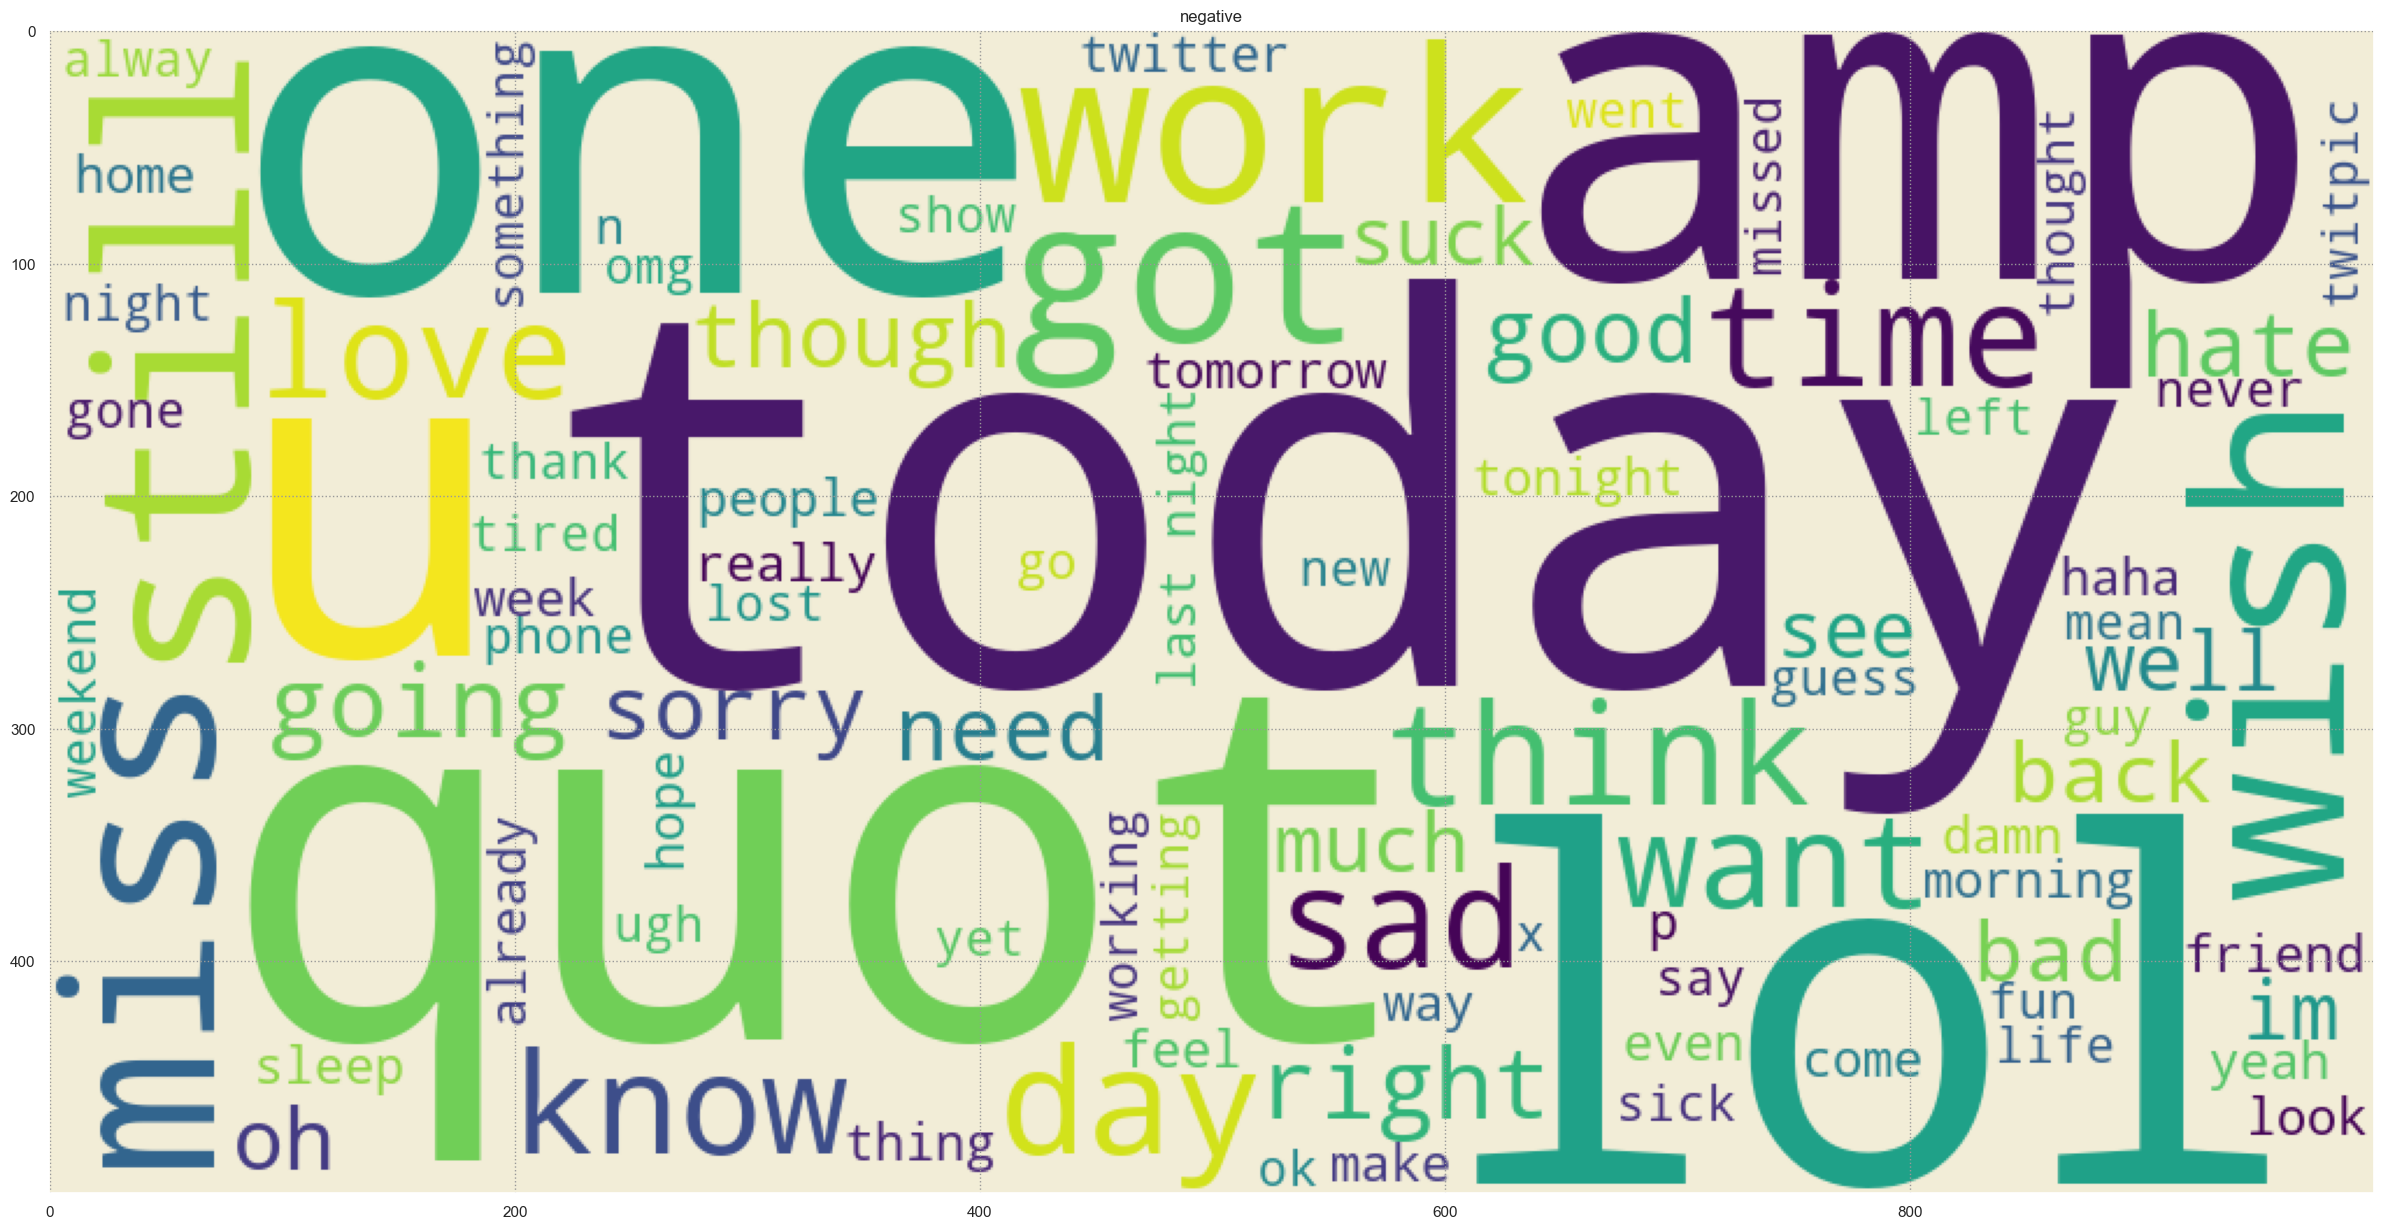

In [28]:
WordCloud()
wordcloud = WordCloud(width=1000,
                      height=500,
                      background_color='#F2EDD7FF',
                      max_words = 90).generate(negative_all)

plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.title("negative")
plt.show()

In [29]:
def get_count(data):
    dic = {}
    for i in data:
        for j in i:
            if j not in dic:
                dic[j]=1
            else:
                dic[j]+=1    
            
    return(dic)

count_corpus = get_count(positive)

In [30]:
count_corpus = pd.DataFrame({"word":count_corpus.keys(),"count":count_corpus.values()})
count_corpus = count_corpus.sort_values(by = "count", ascending = False)

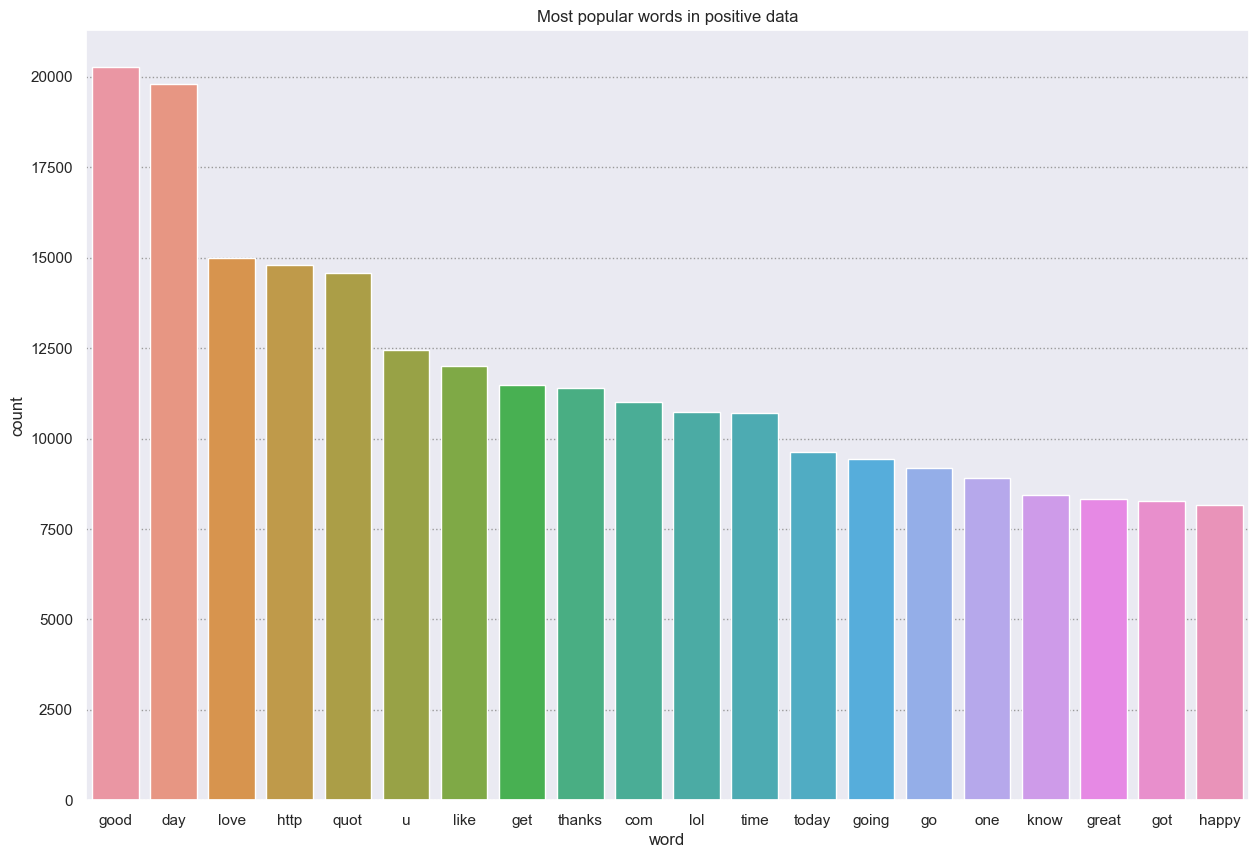

In [31]:
plt.figure(figsize = (15,10))
sns.barplot(x = count_corpus["word"][:20], y = count_corpus["count"][:20])
plt.title('Most popular words in positive data')
plt.show()

In [32]:
def get_count(data):
    dic = {}
    for i in data:
        for j in i:
            if j not in dic:
                dic[j]=1
            else:
                dic[j]+=1    
            
    return(dic)

count_corpus = get_count(negative)

count_corpus = pd.DataFrame({"word":count_corpus.keys(),"count":count_corpus.values()})
count_corpus = count_corpus.sort_values(by = "count", ascending = False)

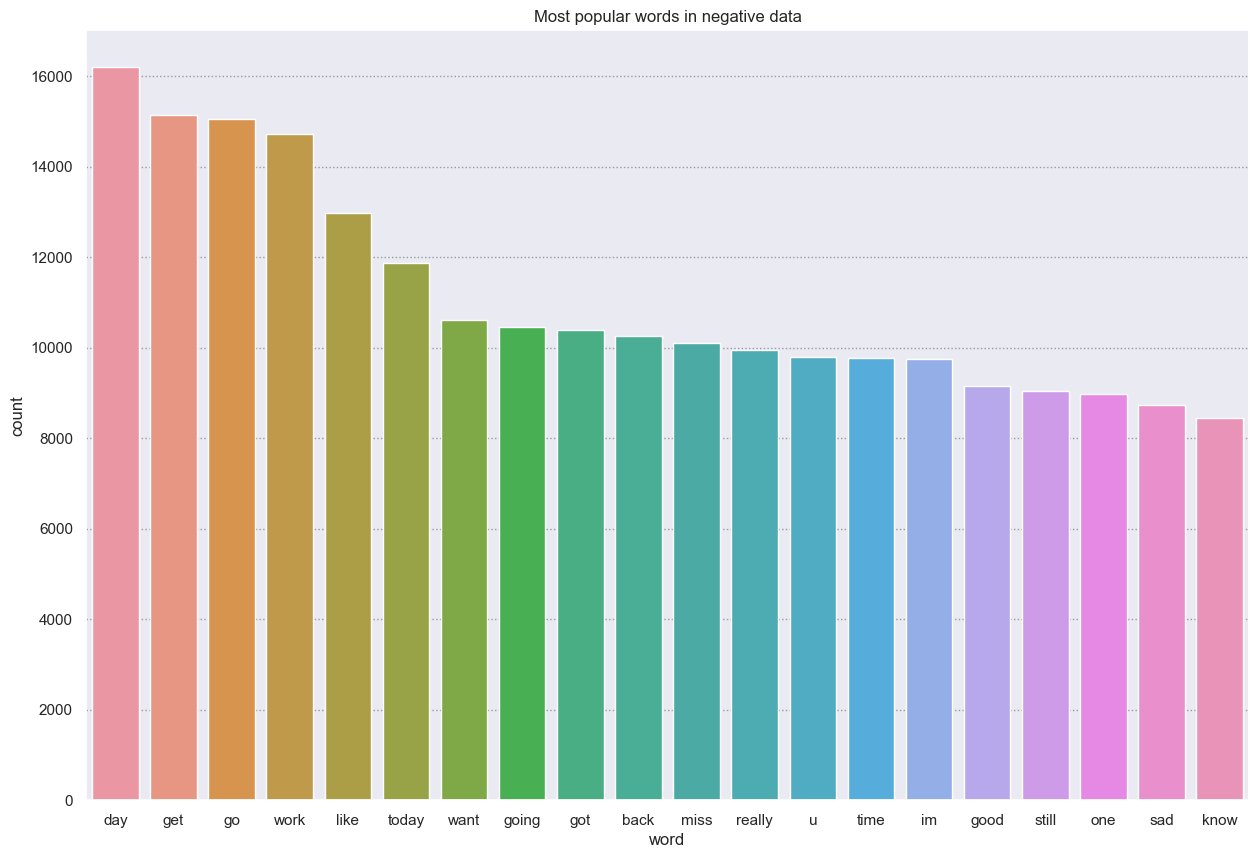

In [33]:
plt.figure(figsize = (15,10))
sns.barplot(x = count_corpus["word"][:20], y = count_corpus["count"][:20])
plt.title('Most popular words in negative data')
plt.show()

### Model

In [24]:
clean_data

,tweets,Class
0,amruth early bird didnt reply facebook wall po...,0
1,sooo hot tonight wish pool outside skinny dipp...,0
2,darkandrez washing clothes,0
3,asexiness suck,0
4,watch yet finale ai waiting replay always miss...,0
...,...,...
497147,grandma making dinenr mum,4
497148,mid morning snack time bowl cheese noodle yum,4
497149,shadela say like terminiator movie come like word,4
497150,destinyhope im great thaanks wbuu,4


In [25]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(clean_data['tweets'])

In [26]:
sequences = tokenizer.texts_to_sequences(clean_data['tweets'])

max_length = max(len(seq) for seq in sequences)
# Pad the sequences to have the same length
padded_sequences = pad_sequences(sequences, maxlen=max_length)

In [30]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [78]:
clean_data['Class'] = clean_data['Class'].apply(lambda x: 1 if x == 4 else 0)

In [81]:
labels = to_categorical(np.asarray(clean_data['Class']))

# Split the dataset into training and testing sets
split_ratio = 0.9
split_index = int(len(padded_sequences) * split_ratio)

x_train = padded_sequences[:split_index]
x_test = padded_sequences[split_index:]

In [82]:
y_train = np.asarray(clean_data['Class']).astype('float32').reshape((-1,1))[:split_index]
y_test = np.asarray(clean_data['Class']).astype('float32').reshape((-1,1))[split_index:]

print(y_train.shape)
print(y_test.shape)

(447436, 1)
(49716, 1)


In [83]:
print(x_train.shape)
print(x_test.shape)

(447436, 34)
(49716, 34)


In [87]:
vocabulary_size = x_train.shape[0]

model = Sequential()
model.add(Embedding(input_dim=vocabulary_size, output_dim=100, input_length=max_length))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 34, 100)           44743600  
                                                                 
 lstm_7 (LSTM)               (None, 34, 128)           117248    
                                                                 
 dropout_4 (Dropout)         (None, 34, 128)           0         
                                                                 
 lstm_8 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 44,910,321
Trainable params: 44,910,321


In [88]:
model.compile(loss='binary_crossentropy', 
             optimizer='adam', 
             metrics=['accuracy'])

In [90]:
batch_size = 128
num_epochs = 2
    
model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=num_epochs)

Epoch 1/2
3496/3496 [==============================] - 1838s 526ms/step - loss: 0.4780 - accuracy: 0.7676 - val_loss: 0.5460 - val_accuracy: 0.7444
Epoch 2/2
3496/3496 [==============================] - 1916s 548ms/step - loss: 0.4547 - accuracy: 0.7814 - val_loss: 0.5521 - val_accuracy: 0.7111


In [92]:
# The above code compiled over 1.5 hours, if we choose more epochs or make RNN deeper we can take better results

In [93]:
import pickle

# Assuming that you have trained and saved your model as 'model'
with open('model.pkl', 'wb') as f:
    # Pickle the 'model' object to the file
    pickle.dump(model, f)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\dense
......vars
.........0
.........1
...layers\dropout
......vars
...layers\dropout_1
......vars
...layers\embedding
......vars
.........0
...layers\lstm
......vars
...layers\lstm\cell
......vars
.........0
.........1
.........2
...layers\lstm_1
......vars
...layers\lstm_1\cell
......vars
.........0
.........1
.........2
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-05-04 15:54:39         3336
metadata.json                                  2

In [119]:
with open('model.pkl', 'rb') as f:
    model1 = pickle.load(f)

# Define a function to preprocess the text input
def preprocess(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    text=re.sub("(\\d|\\W)+"," ",text)
    text = text.split()
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in words_removed] 
    
    return ' '.join(text)

# Define a function to predict the sentiment of a text input
def predict_sentiment(model, text):
    # Preprocess the text input
    text = preprocess(text)
    # Vectorize the preprocessed text using the same vectorizer used for training the model
    text_vectorized = tokenizer.texts_to_sequences([text])
    padded_sequences = pad_sequences(text_vectorized, maxlen=34)
    # Make the prediction using the loaded model
    prediction = model.predict(padded_sequences)[0]
    # Return the predicted sentiment label (0 or 1)
    return prediction

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-05-04 15:54:38         3336
metadata.json                                  2023-05-04 15:54:38           64
variables.h5                                   2023-05-04 15:54:40    538958184
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\dense
......vars
.........0
.........1
...layers\dropout
......vars
...layers\dropout_1
......vars
...layers\embedding
......vars
.........0
...layers\lstm
......vars
...layers\lstm\cell
......vars
.........0
.........1
.........2
...layers\lstm_1
......vars
...layers\lstm_1\cell
......vars
.........0
.........1
.........2
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.......

In [120]:
t = 'Are you stupid!'

new_t = preprocess(t)
new_t

'stupid'

In [121]:
round(predict_sentiment(model1, new_t)[0])

1/1 [==============================] - 1s 752ms/step


0

In [123]:
model.save('my_model.h5')